<a href="https://colab.research.google.com/github/Jasada7/Machine-Learning/blob/main/Pokemon_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle # ติดตั้ง Kaggle API

In [2]:
 # อัปโหลด Kaggle API Token เข้าสู่ Google Colab
!mkdir -p ~/.kaggle
!echo '{"username":"jasada","key":"b7743352be254017e3163b2876177dc1"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
 # ข้อมูลจาก https://www.kaggle.com/datasets/rohanpatil63/pokemon-dataset?select=pokemon.csv

In [3]:
import kaggle

# เชื่อมต่อ Kaggle API
kaggle.api.authenticate()

# ดาวน์โหลดชุดข้อมูล oceanic-life-dataset
kaggle.api.dataset_download_files('rohanpatil63/pokemon-dataset')

# แตกไฟล์ลงใน '/content/pokemon-dataset/'
!unzip '/content/pokemon-dataset.zip' -d '/content/pokemon-dataset/'

Archive:  /content/pokemon-dataset.zip
  inflating: /content/pokemon-dataset/Pokemon/abomasnow.jpg  
  inflating: /content/pokemon-dataset/Pokemon/abra.jpg  
  inflating: /content/pokemon-dataset/Pokemon/absol.jpg  
  inflating: /content/pokemon-dataset/Pokemon/accelgor.jpg  
  inflating: /content/pokemon-dataset/Pokemon/aegislash.jpg  
  inflating: /content/pokemon-dataset/Pokemon/aerodactyl.jpg  
  inflating: /content/pokemon-dataset/Pokemon/aggron.jpg  
  inflating: /content/pokemon-dataset/Pokemon/aipom.jpg  
  inflating: /content/pokemon-dataset/Pokemon/alakazam.jpg  
  inflating: /content/pokemon-dataset/Pokemon/alcremie.jpg  
  inflating: /content/pokemon-dataset/Pokemon/alomomola.jpg  
  inflating: /content/pokemon-dataset/Pokemon/altaria.jpg  
  inflating: /content/pokemon-dataset/Pokemon/amaura.jpg  
  inflating: /content/pokemon-dataset/Pokemon/ambipom.jpg  
  inflating: /content/pokemon-dataset/Pokemon/amoonguss.jpg  
  inflating: /content/pokemon-dataset/Pokemon/ampharos.j

In [105]:
import pandas as pd

# เส้นทางไปยังไฟล์ "pokemon.csv"
csv_path = '/content/pokemon-dataset/pokemon.csv'

# อ่านไฟล์ "pokemon.csv" และสร้าง DataFrame
df = pd.read_csv(csv_path)

# ปรับค่าในคอลัมน์ 'image_url' เป็นเส้นทางของรูปภาพโปเกมอนที่อยู่ในโฟลเดอร์ '/content/pokemon-dataset/Pokemon/'
df['image_url'] = df['Names'].apply(lambda x: f'/content/pokemon-dataset/Pokemon/{x.lower()}.jpg')

# ใช้ฟังก์ชัน str.replace() ใน pandas เพื่อแทนที่ช่องว่างด้วยอย่างอื่น ๆ เช่น "_"
df['image_url'] = df['image_url'].str.replace(' ', '-')

# ลบคอลัมน์ 'Unnamed: 0' ออกจาก DataFrame
df.drop('Unnamed: 0', axis=1, inplace=True)

# ตั้งคอลัมน์ 'Id' เป็น index
df.set_index('Id', inplace=True)

# เปลี่ยนค่าในคอลัมน์ 'Type2' ที่เป็น NaN เป็นค่าในคอลัมน์ 'Type1'
df['Type2'].fillna(df['Type1'], inplace=True)

df

,image_url,Names,Type1,Type2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
Id,,,,,,,,,,,
1,/content/pokemon-dataset/Pokemon/bulbasaur.jpg,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45
2,/content/pokemon-dataset/Pokemon/ivysaur.jpg,Ivysaur,Grass,Poison,405,60,62,63,80,80,60
3,/content/pokemon-dataset/Pokemon/venusaur.jpg,Venusaur,Grass,Poison,525,80,82,83,100,100,80
3,/content/pokemon-dataset/Pokemon/venusaur-mega...,Venusaur Mega Venusaur,Grass,Poison,625,80,100,123,122,120,80
4,/content/pokemon-dataset/Pokemon/charmander.jpg,Charmander,Fire,Fire,309,39,52,43,60,50,65
...,...,...,...,...,...,...,...,...,...,...,...
1006,/content/pokemon-dataset/Pokemon/iron-valiant.jpg,Iron Valiant,Fairy,Fighting,590,74,130,90,120,60,116
1007,/content/pokemon-dataset/Pokemon/koraidon.jpg,Koraidon,Fighting,Dragon,670,100,135,115,85,100,135
1008,/content/pokemon-dataset/Pokemon/miraidon.jpg,Miraidon,Electric,Dragon,670,100,85,100,135,115,135


In [106]:
import os

# กำหนดโฟลเดอร์ที่มีข้อมูลภายใน
data_directory = '/content/pokemon-dataset'
image_files = os.path.join(data_directory, 'Pokemon')
image_list = os.listdir(image_files)

# จริงๆ ใช้ Spark ในการหาจะง่ายกว่า แต่เพื่อการศึกษาจริงทำให้เข้าใจง่ายไว้ก่อน

In [107]:
# หาเซตของค่าในคอลัมน์ "image_url" ที่เก็บชื่อไฟล์รูปภาพเท่านั้น
df_image_files = set(os.path.basename(image_url) for image_url in df['image_url'])

# สร้างเซตของไฟล์ในโฟลเดอร์ "Pokemon"
pokemon_files = set(image_list)

# เปรียบเทียบเซตเพื่อดูว่าตรงกันหรือไม่
if df_image_files == pokemon_files:
    print("ค่าในคอลัมน์ image_url ตรงกับไฟล์ในโฟลเดอร์ Pokemon")
else:
    print("ค่าในคอลัมน์ image_url ไม่ตรงกับไฟล์ในโฟลเดอร์ Pokemon")

# แสดงรายการรูปภาพที่ไม่ตรงกัน
not_found_images = df_image_files - pokemon_files
print("รูปภาพที่ไม่พบในโฟลเดอร์ Pokemon:")
for image_filename in not_found_images:
    print(image_filename)

ค่าในคอลัมน์ image_url ไม่ตรงกับไฟล์ในโฟลเดอร์ Pokemon
รูปภาพที่ไม่พบในโฟลเดอร์ Pokemon:
tadbulb.jpg
palkia-origin-forme.jpg
bramblin.jpg
ninetales-alolan-ninetales.jpg
eiscue-ice-face.jpg
enamorus-therian-forme.jpg
shroodle.jpg
articuno-galarian-articuno.jpg
kyurem-white-kyurem.jpg
farfetch'd.jpg
necrozma-dawn-wings-necrozma.jpg
charizard-mega-charizard-x.jpg
oricorio-pom-pom-style.jpg
wishiwashi-school-form.jpg
tatsugiri-droopy-form.jpg
morpeko-full-belly-mode.jpg
pawmi.jpg
exeggutor-alolan-exeggutor.jpg
diancie-mega-diancie.jpg
wormadam-sandy-cloak.jpg
zygarde-50%-forme.jpg
zoroark-hisuian-zoroark.jpg
shaymin-land-forme.jpg
toxtricity-low-key-form.jpg
lycanroc-dusk-form.jpg
calyrex-shadow-rider.jpg
gourgeist-super-size.jpg
manectric-mega-manectric.jpg
brambleghast.jpg
nymble.jpg
garganacl.jpg
stunfisk-galarian-stunfisk.jpg
hoopa-hoopa-unbound.jpg
muk-alolan-muk.jpg
venusaur-mega-venusaur.jpg
gengar-mega-gengar.jpg
moltres-galarian-moltres.jpg
typhlosion-hisuian-typhlosion.jpg
pumpka

# ลบเพราะว่าไม่มีรูปภาพ Pokemon พวกนี้เพราะเป็น Gen ใหม่ยังไม่ได้รวบรวมข้อมูลมา

In [108]:
# หาแถวที่คอลัมน์ "image_url" ไม่ตรงกับไฟล์ในโฟลเดอร์ "Pokemon"
rows_to_drop = df[~df['image_url'].apply(lambda x: os.path.basename(x)).isin(pokemon_files)].index

# ลบแถวที่คอลัมน์ "image_url" ไม่ตรงกับไฟล์ในโฟลเดอร์ "Pokemon" ออกจาก DataFrame
df.drop(index=rows_to_drop, inplace=True)

# รีเซตดัชนีของ DataFrame ใหม่หากต้องการ
df.reset_index(drop=True, inplace=True)

df

,image_url,Names,Type1,Type2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,/content/pokemon-dataset/Pokemon/bulbasaur.jpg,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45
1,/content/pokemon-dataset/Pokemon/ivysaur.jpg,Ivysaur,Grass,Poison,405,60,62,63,80,80,60
2,/content/pokemon-dataset/Pokemon/charmander.jpg,Charmander,Fire,Fire,309,39,52,43,60,50,65
3,/content/pokemon-dataset/Pokemon/charmeleon.jpg,Charmeleon,Fire,Fire,405,58,64,58,80,65,80
4,/content/pokemon-dataset/Pokemon/squirtle.jpg,Squirtle,Water,Water,314,44,48,65,50,64,43
...,...,...,...,...,...,...,...,...,...,...,...
750,/content/pokemon-dataset/Pokemon/wyrdeer.jpg,Wyrdeer,Normal,Psychic,525,103,105,72,105,75,65
751,/content/pokemon-dataset/Pokemon/kleavor.jpg,Kleavor,Bug,Rock,500,70,135,95,45,70,85
752,/content/pokemon-dataset/Pokemon/ursaluna.jpg,Ursaluna,Ground,Normal,550,130,140,105,45,80,50
753,/content/pokemon-dataset/Pokemon/sneasler.jpg,Sneasler,Fighting,Poison,510,80,130,60,40,80,120


##ตรวจ

In [109]:
# หาเซตของค่าในคอลัมน์ "image_url" ที่เก็บชื่อไฟล์รูปภาพเท่านั้น
df_image_files = set(os.path.basename(image_url) for image_url in df['image_url'])

# สร้างเซตของไฟล์ในโฟลเดอร์ "Pokemon"
pokemon_files = set(image_list)

# เปรียบเทียบเซตเพื่อดูว่าตรงกันหรือไม่
if df_image_files == pokemon_files:
    print("ค่าในคอลัมน์ image_url ตรงกับไฟล์ในโฟลเดอร์ Pokemon")
else:
    print("ค่าในคอลัมน์ image_url ไม่ตรงกับไฟล์ในโฟลเดอร์ Pokemon")

# แสดงรายการรูปภาพที่ไม่ตรงกัน
not_found_images = df_image_files - pokemon_files
print("รูปภาพที่ไม่พบในโฟลเดอร์ Pokemon:")
for image_filename in not_found_images:
    print(image_filename)

ค่าในคอลัมน์ image_url ไม่ตรงกับไฟล์ในโฟลเดอร์ Pokemon
รูปภาพที่ไม่พบในโฟลเดอร์ Pokemon:


In [110]:
# ตรวจสอบข้อมูลของ DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 755 entries, 0 to 754
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   image_url  755 non-null    object
 1   Names      755 non-null    object
 2   Type1      755 non-null    object
 3   Type2      755 non-null    object
 4   Total      755 non-null    int64 
 5   HP         755 non-null    int64 
 6   Attack     755 non-null    int64 
 7   Defense    755 non-null    int64 
 8   Sp. Atk    755 non-null    int64 
 9   Sp. Def    755 non-null    int64 
 10  Speed      755 non-null    int64 
dtypes: int64(7), object(4)
memory usage: 65.0+ KB


In [111]:
# ตรวจสอบค่า Null ในแต่ละคอลัมน์
df.isnull().sum()

image_url    0
Names        0
Type1        0
Type2        0
Total        0
HP           0
Attack       0
Defense      0
Sp. Atk      0
Sp. Def      0
Speed        0
dtype: int64

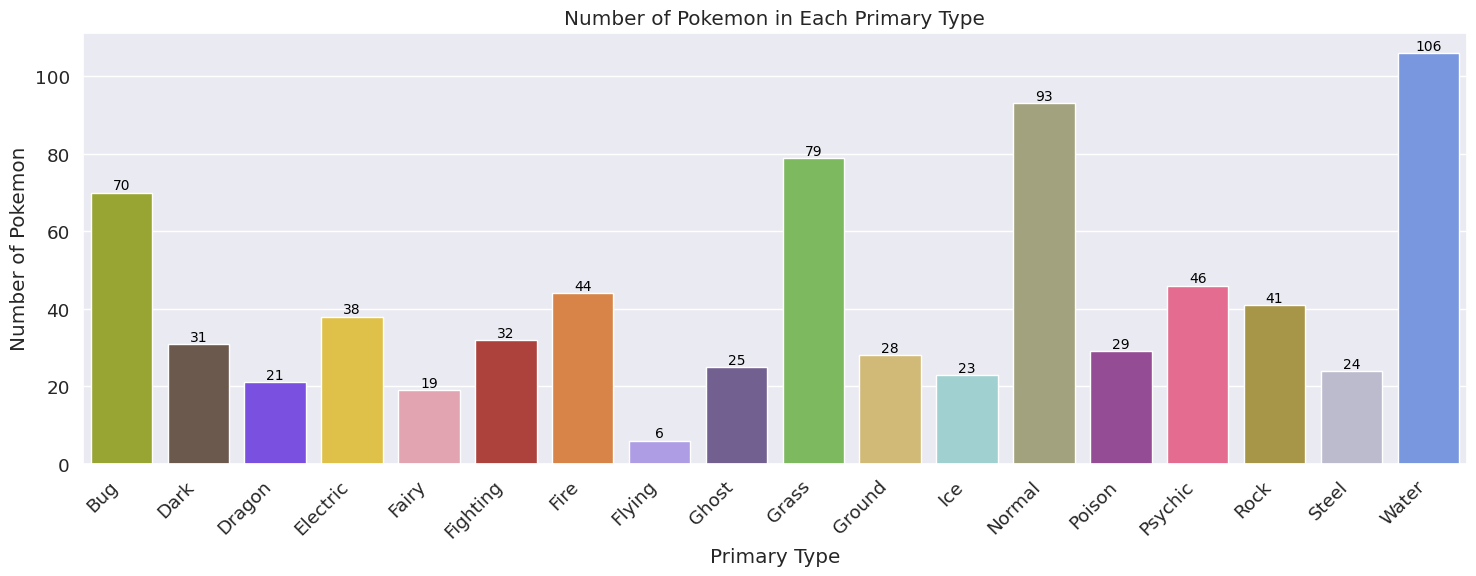

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns

custom_colors = {
    'Bug': '#a8b820',
    'Dark': '#705848',
    'Dragon': '#7038f8',
    'Electric': '#f8d030',
    'Fairy': '#ee99ac',
    'Fighting': '#c03028',
    'Fire': '#f08030',
    'Flying': '#a890f0',
    'Ghost': '#705898',
    'Grass': '#78c850',
    'Ground': '#e0c068',
    'Ice': '#98d8d8',
    'Normal': '#a8a878',
    'Poison': '#a040a0',
    'Psychic': '#f85888',
    'Rock': '#b8a038',
    'Steel': '#b8b8d0',
    'Water': '#6890f0'
}

type1 = list(custom_colors.keys())
type1_nums = []
for type in type1:
  type1_nums.append(sum(df['Type1']==type))

type1_data = pd.DataFrame(data=type1_nums, index=type1, columns=['# of pokemon'])

# ขนาดของกราฟและขนาดตัวอักษร
plt.figure(figsize=(15, 6))
sns.set(font_scale=1.2)

# สีสันของกราฟ
sns.set_palette(sns.color_palette(custom_colors.values()))

# แสดงชื่อของ type ในแนวแกน x และให้ตัวอักษรหมุนให้สอดคล้อง
ax = sns.barplot(x=type1_data.index, y='# of pokemon', data=type1_data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

# เพิ่มชื่อแกน x และแกน y และชื่อกราฟ
plt.xlabel("Primary Type")
plt.ylabel("Number of Pokemon")
plt.title("Number of Pokemon in Each Primary Type")

# แสดงตัวเลขบนแท่ง
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()


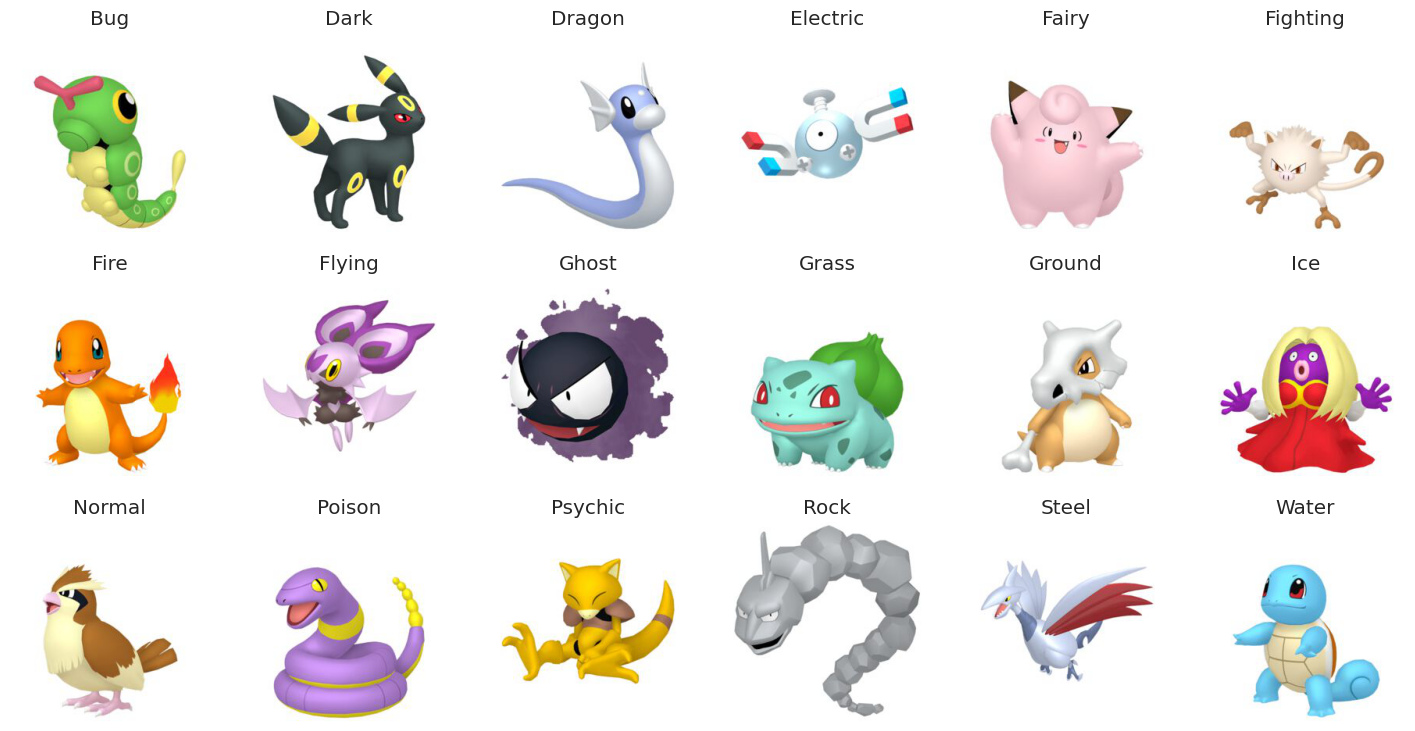

In [113]:
import matplotlib.image as mpimg

# หาข้อมูลและแสดงรูปภาพและชื่อ Pokemon ของประเภทแต่ละชนิดที่เกิดขึ้นครั้งแรก
first_row_indices = []
for type in type1:
    first_row_indices.append(df[df['Type1'] == type].index[0])

imgs = []
for index in first_row_indices:
    image_path = df.iat[index, 0]
    if os.path.exists(image_path):  # ตรวจสอบเส้นทางรูปภาพก่อนโหลด
        imgs.append(mpimg.imread(image_path))

f, axarr = plt.subplots(3, 6, figsize=(18, 9))
count = 0
for r in range(3):
    for c in range(6):
        if count < len(imgs):  # ตรวจสอบว่ามีรูปภาพในช่องนั้นหรือไม่
            axarr[r, c].imshow(imgs[count])
            axarr[r, c].set_title(type1[count])
            axarr[r, c].set_axis_off()
        count += 1
plt.show()


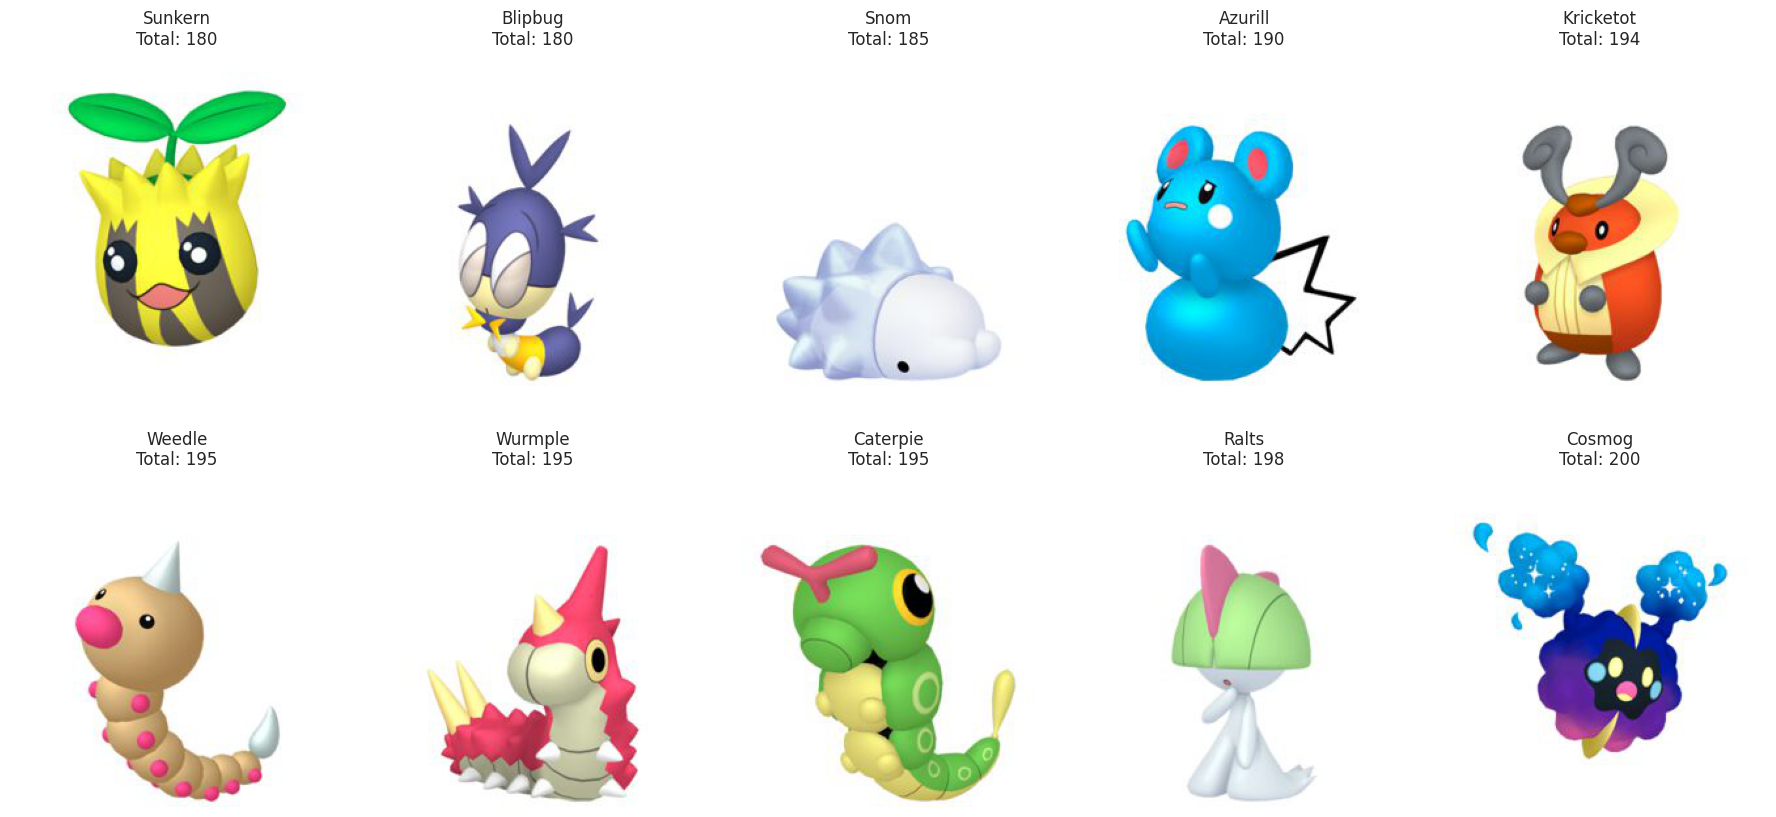

In [114]:
#Pokemon ที่มีค่าสถิติต่ำสุด 10 อันดับ
sorted_pokemon_df = df.sort_values(by='Total')

# จำนวน Pokemon ที่ต้องการแสดงรูปภาพ
num_pokemon_to_display = 10

# ตั้งขนาดของรูปภาพ
plt.figure(figsize=(18, 9))

# ลูปเพื่อแสดงรูปภาพของ Pokemon ที่มีค่าสถิติสะสม (Total) ต่ำสุด 10 อันดับแรก
for i, (name, total) in enumerate(sorted_pokemon_df[['Names', 'Total']].head(num_pokemon_to_display).itertuples(index=False)):
    image_path = sorted_pokemon_df.loc[sorted_pokemon_df['Names'] == name, 'image_url'].values[0]
    if os.path.exists(image_path):  # ตรวจสอบเส้นทางรูปภาพก่อนโหลด
        plt.subplot(2, 5, i + 1)  # กำหนดตำแหน่งของกราฟใน grid ขนาด 2x5
        plt.imshow(mpimg.imread(image_path))
        plt.title(f'{name}\nTotal: {total}', fontsize=12)
        plt.axis('off')

# แสดงรูปภาพ
plt.tight_layout()
plt.show()

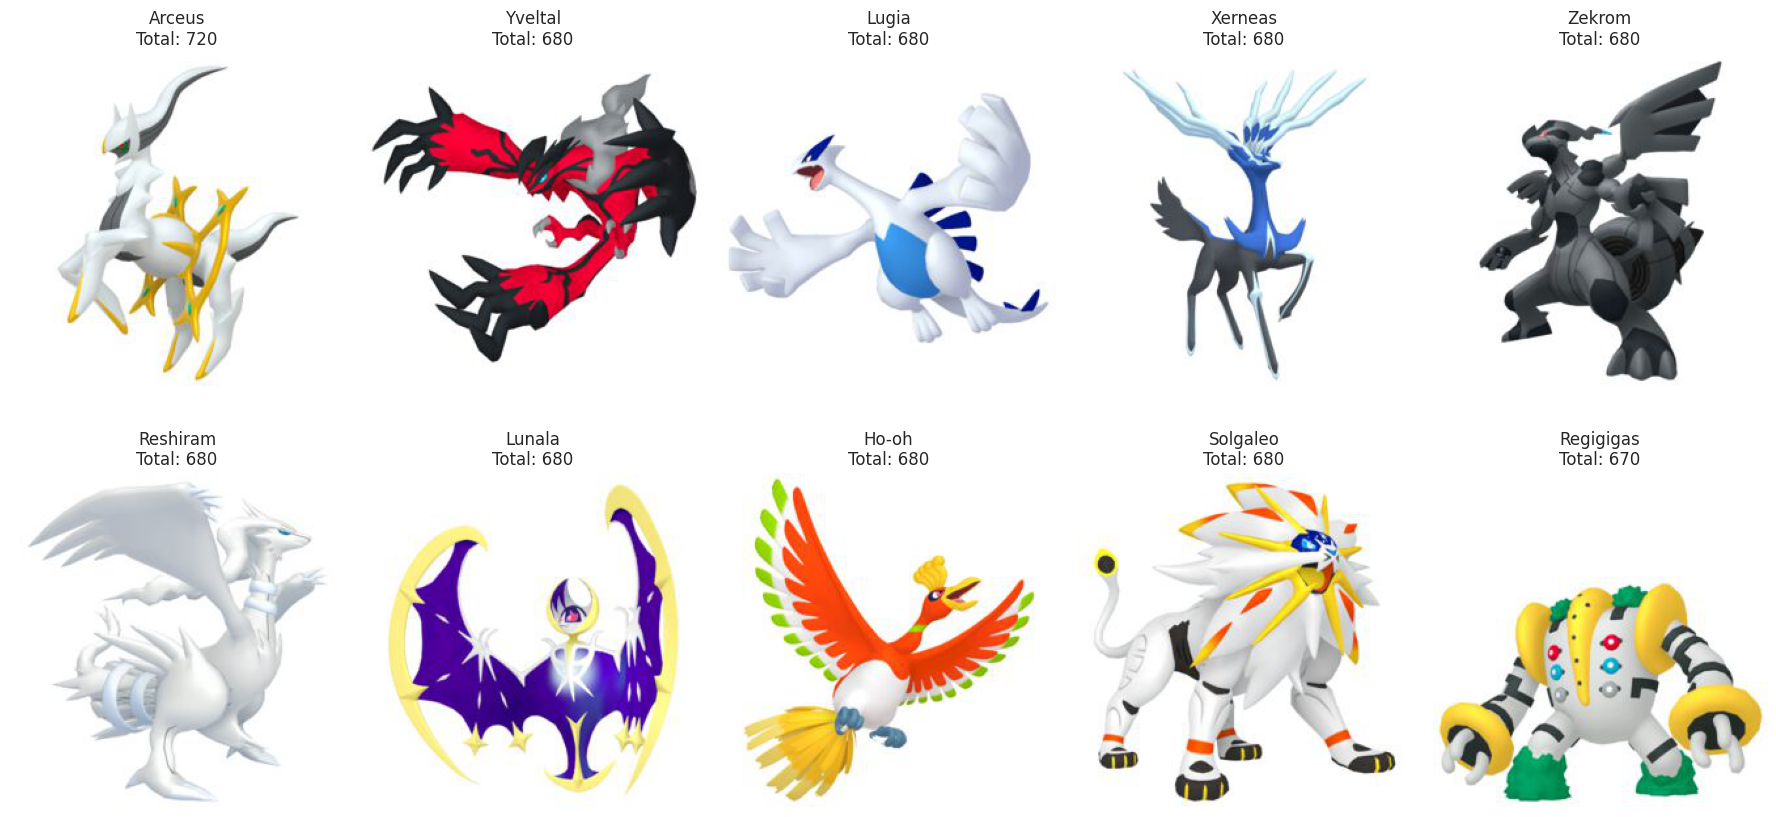

In [115]:
#Pokemon ที่มีค่าสถิติต่ำสุด 10 อันดับ
sorted_pokemon_df = df.sort_values(by='Total', ascending=False)

# จำนวน Pokemon ที่ต้องการแสดงรูปภาพ
num_pokemon_to_display = 10

# ตั้งขนาดของรูปภาพ
plt.figure(figsize=(18, 9))

# แสดงรูปภาพของ Pokemon ที่มีค่าสถิติสะสม (Total) สูงสุดไว้ที่รูปแรก
image_path = sorted_pokemon_df.loc[sorted_pokemon_df.index[0], 'image_url']
if os.path.exists(image_path):  # ตรวจสอบเส้นทางรูปภาพก่อนโหลด
    plt.subplot(2, 5, 1)  # กำหนดตำแหน่งของกราฟใน grid ขนาด 2x5
    plt.imshow(mpimg.imread(image_path))
    plt.title(f'{sorted_pokemon_df.iloc[0]["Names"]}\nTotal: {sorted_pokemon_df.iloc[0]["Total"]}', fontsize=12)
    plt.axis('off')

# ลูปเพื่อแสดงรูปภาพของ Pokemon ที่มีค่าสถิติสะสม (Total) ต่ำกว่าที่รูปแรกและมากกว่าที่รูปแรก (เหมือนเดิม)
for i, (name, total) in enumerate(sorted_pokemon_df[['Names', 'Total']].iloc[1:num_pokemon_to_display].itertuples(index=False)):
    image_path = sorted_pokemon_df.loc[sorted_pokemon_df['Names'] == name, 'image_url'].values[0]
    if os.path.exists(image_path):  # ตรวจสอบเส้นทางรูปภาพก่อนโหลด
        plt.subplot(2, 5, i + 2)  # กำหนดตำแหน่งของกราฟใน grid ขนาด 2x5
        plt.imshow(mpimg.imread(image_path))
        plt.title(f'{name}\nTotal: {total}', fontsize=12)
        plt.axis('off')

# แสดงรูปภาพ
plt.tight_layout()
plt.show()

In [116]:
def calculate_battle(pokemon1, pokemon2):
    total_pokemon1 = pokemon1['Total']
    total_pokemon2 = pokemon2['Total']

    if total_pokemon1 > total_pokemon2:
        return pokemon1['Names']
    elif total_pokemon1 < total_pokemon2:
        return pokemon2['Names']
    else:
        return 'Draw'


In [117]:
df['Win_Percentage'] = 0.0

for index, row in df.iterrows():
    wins = 0
    total_pokemon = len(df) - 1  # ลบตัวเองออกจากจำนวน Pokemon ที่ต้องทำการต่อสู้

    for _, other_row in df.iterrows():
        if index != _:
            if calculate_battle(row, other_row) == row['Names']:
                wins += 1

    win_percentage = (wins / total_pokemon) * 100
    df.at[index, 'Win_Percentage'] = win_percentage

# เรียงลำดับ DataFrame ตามค่า 'Win_Percentage'
df_sorted = df.sort_values(by='Win_Percentage', ascending=False)

# แสดงค่า DataFrame ที่ถูกเรียงลำดับและมีคอลัมน์ 'Win_Percentage' ที่คำนวณมาแล้ว
df_sorted

,image_url,Names,Type1,Type2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Win_Percentage
392,/content/pokemon-dataset/Pokemon/arceus.jpg,Arceus,Normal,Normal,720,120,120,120,120,120,120,100.000000
590,/content/pokemon-dataset/Pokemon/yveltal.jpg,Yveltal,Dark,Flying,680,126,131,95,131,98,99,98.938992
187,/content/pokemon-dataset/Pokemon/lugia.jpg,Lugia,Psychic,Flying,680,106,90,130,90,154,110,98.938992
589,/content/pokemon-dataset/Pokemon/xerneas.jpg,Xerneas,Fairy,Fairy,680,126,131,95,131,98,99,98.938992
530,/content/pokemon-dataset/Pokemon/zekrom.jpg,Zekrom,Dragon,Electric,680,100,150,120,120,100,90,98.938992
...,...,...,...,...,...,...,...,...,...,...,...,...
313,/content/pokemon-dataset/Pokemon/kricketot.jpg,Kricketot,Bug,Bug,194,37,25,41,25,41,25,0.530504
230,/content/pokemon-dataset/Pokemon/azurill.jpg,Azurill,Normal,Fairy,190,50,20,40,20,40,20,0.397878
731,/content/pokemon-dataset/Pokemon/snom.jpg,Snom,Ice,Bug,185,30,25,35,45,30,20,0.265252
686,/content/pokemon-dataset/Pokemon/blipbug.jpg,Blipbug,Bug,Bug,180,25,20,20,25,45,45,0.000000


# Win_Percentage เป็นแค่ Pokemon ที่มีค่า Total	มากสุดจะชนะไปแต่ยังไม่รวมเงื่อนไขของธาตุ

In [118]:
def calculate_normal_effective(row):
    very_effective = {
        'Normal': [],
        'Fight': ['Normal', 'Rock', 'Steel', 'Ice', 'Dark'],
        'Flying': ['Fight', 'Bug', 'Grass'],
        'Poison': ['Grass', 'Fairy'],
        'Ground': ['Poison', 'Rock', 'Steel', 'Fire', 'Electric'],
        'Rock': ['Flying', 'Bug', 'Fire', 'Ice'],
        'Bug': ['Grass', 'Psychic', 'Dark'],
        'Ghost': ['Ghost', 'Psychic'],
        'Steel': ['Rock', 'Ice', 'Fairy'],
        'Fire': ['Bug', 'Steel', 'Grass', 'Ice'],
        'Water': ['Ground', 'Rock', 'Fire'],
        'Grass': ['Ground', 'Rock', 'Water'],
        'Electric': ['Flying', 'Water'],
        'Psychic': ['Fight', 'Poison'],
        'Ice': ['Flying', 'Ground', 'Grass', 'Dragon'],
        'Dragon': ['Dragon'],
        'Dark': ['Ghost', 'Psychic'],
        'Fairy': ['Fight', 'Dragon', 'Dark']
    }

    not_very_effective = {
        'Normal': ['Rock', 'Steel'],
        'Fight': ['Flying', 'Poison', 'Bug', 'Psychic', 'Fairy'],
        'Flying': ['Rock', 'Steel', 'Electric'],
        'Poison': ['Poison', 'Rock', 'Ground', 'Ghost'],
        'Ground': ['Bug', 'Grass'],
        'Rock': ['Fight', 'Ground', 'Steel'],
        'Bug': ['Fight', 'Flying', 'Poison', 'Ghost', 'Steel', 'Fire', 'Fairy'],
        'Ghost': ['Dark'],
        'Steel': ['Steel', 'Fire', 'Water', 'Electric'],
        'Fire': ['Rock', 'Fire', 'Water', 'Dragon'],
        'Water': ['Water', 'Grass', 'Dragon'],
        'Grass': ['Flying', 'Poison', 'Bug', 'Steel', 'Fire', 'Grass', 'Dragon'],
        'Electric': ['Grass', 'Electric', 'Dragon'],
        'Psychic': ['Steel', 'Psychic'],
        'Ice': ['Steel', 'Fire', 'Water', 'Psychic'],
        'Dragon': ['Steel'],
        'Dark': ['Fight', 'Dark', 'Fairy'],
        'Fairy': ['Posion', 'Steel', 'Fire']
    }

    not_effective = {
        'Normal': ['Ghost'],
        'Fight': ['Ghost'],
        'Flying': [],
        'Poison': ['Steel'],
        'Ground': ['Flying'],
        'Rock': [],
        'Bug': [],
        'Ghost': ['Normal'],
        'Steel': [],
        'Fire': [],
        'Water': [],
        'Grass': [],
        'Electric': ['Ground'],
        'Psychic': ['Dark'],
        'Ice': [],
        'Dragon': ['Fairy'],
        'Dark': [],
        'Fairy': []
    }

    normal_effective = {
        'Normal': ['Normal'],
        'Fight': ['Fight'],
        'Flying': ['Flying'],
        'Poison': ['Poison'],
        'Ground': ['Ground'],
        'Rock': ['Rock'],
        'Bug': ['Bug'],
        'Ghost': ['Ghost'],
        'Steel': ['Steel'],
        'Fire': ['Fire'],
        'Water': ['Water'],
        'Grass': ['Grass'],
        'Electric': ['Electric'],
        'Psychic': ['Psychic'],
        'Ice': ['Ice'],
        'Dragon': ['Dragon'],
        'Dark': ['Dark'],
        'Fairy': ['Fairy']
    }

    type1 = row['Type1']
    type2 = row['Type2']
    attack = row['Attack']

    if type1 in very_effective:
        return attack * 2
    elif type1 in not_very_effective:
        return attack / 2
    elif type1 in not_effective:
        return 0

    if type1 in normal_effective:
        if type2 in very_effective:
            return attack * 2
        elif type2 in not_very_effective:
            return attack / 2
        elif type2 in not_effective:
            return 0

    return attack

In [119]:
def calculate_battle_result(pokemon1, pokemon2):
    # คำนวณค่า Total สำหรับทั้งสอง Pokemon
    total_pokemon1 = pokemon1['HP'] + calculate_normal_effective(pokemon1) + pokemon1['Defense'] + pokemon1['Sp. Atk'] + pokemon1['Sp. Def'] + pokemon1['Speed']
    total_pokemon2 = pokemon2['HP'] + calculate_normal_effective(pokemon2) + pokemon2['Defense'] + pokemon2['Sp. Atk'] + pokemon2['Sp. Def'] + pokemon2['Speed']

    # ตรวจสอบว่า Pokemon ใดมี Total มากกว่า
    if total_pokemon1 > total_pokemon2:
        return pokemon1['Names']
    elif total_pokemon2 > total_pokemon1:
        return pokemon2['Names']
    else:
        return 'Draw'

In [120]:
# ค่า Win_Percentage สำหรับ Pokemon 1 ตัวที่ทำการต่อสู้กับทุกตัวยกเว้นตัวเอง
win_percentage_list = []
for i, pokemon1 in df_sorted.iterrows():
    wins = df_sorted.apply(lambda row: 1 if calculate_battle_result(pokemon1, row) == pokemon1['Names'] else 0, axis=1).sum()
    percentage = wins / (len(df_sorted) - 1) * 100
    win_percentage_list.append(percentage)

# สร้างคอลัมน์ 'Win_Percentage_Type' ใหม่เพื่อเก็บค่า Win_Percentage ที่คำนวณมา
df_sorted['Win_Percentage_Type'] = win_percentage_list

#จะเห็นได้ว่าถ้าเอาแค่ Win_Percentage มาตัดสินจะมี Pokemon บางตัวที่มีค่า Win_Percentage	 เท่ากัน แต่ถ้านำ Type1	และ Type2 มาคิดด้วยก็จะทำให้คำนวณเปอร์เซ็นการชนะแม่นยำขึ้น

In [121]:
df_sorted

,image_url,Names,Type1,Type2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Win_Percentage,Win_Percentage_Type
392,/content/pokemon-dataset/Pokemon/arceus.jpg,Arceus,Normal,Normal,720,120,120,120,120,120,120,100.000000,100.000000
590,/content/pokemon-dataset/Pokemon/yveltal.jpg,Yveltal,Dark,Flying,680,126,131,95,131,98,99,98.938992,99.204244
187,/content/pokemon-dataset/Pokemon/lugia.jpg,Lugia,Psychic,Flying,680,106,90,130,90,154,110,98.938992,98.673740
589,/content/pokemon-dataset/Pokemon/xerneas.jpg,Xerneas,Fairy,Fairy,680,126,131,95,131,98,99,98.938992,99.204244
530,/content/pokemon-dataset/Pokemon/zekrom.jpg,Zekrom,Dragon,Electric,680,100,150,120,120,100,90,98.938992,99.602122
...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,/content/pokemon-dataset/Pokemon/kricketot.jpg,Kricketot,Bug,Bug,194,37,25,41,25,41,25,0.530504,0.928382
230,/content/pokemon-dataset/Pokemon/azurill.jpg,Azurill,Normal,Fairy,190,50,20,40,20,40,20,0.397878,0.132626
731,/content/pokemon-dataset/Pokemon/snom.jpg,Snom,Ice,Bug,185,30,25,35,45,30,20,0.265252,0.132626
686,/content/pokemon-dataset/Pokemon/blipbug.jpg,Blipbug,Bug,Bug,180,25,20,20,25,45,45,0.000000,0.000000


In [758]:
# สร้าง DataFrame ใหม่ที่ประกอบด้วยคอลัมน์ที่ต้องการคัดลอก
new_df = df_sorted[['Win_Percentage_Type', 'Type1', 'Type2', 'Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']].copy()

new_df

,Win_Percentage_Type,Type1,Type2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
392,100.000000,Normal,Normal,720,120,120,120,120,120,120
590,99.204244,Dark,Flying,680,126,131,95,131,98,99
187,98.673740,Psychic,Flying,680,106,90,130,90,154,110
589,99.204244,Fairy,Fairy,680,126,131,95,131,98,99
530,99.602122,Dragon,Electric,680,100,150,120,120,100,90
...,...,...,...,...,...,...,...,...,...,...
313,0.928382,Bug,Bug,194,37,25,41,25,41,25
230,0.132626,Normal,Fairy,190,50,20,40,20,40,20
731,0.132626,Ice,Bug,185,30,25,35,45,30,20
686,0.000000,Bug,Bug,180,25,20,20,25,45,45


In [759]:
# แบ่งข้อมูลเป็น features (X) และ target (y)
X = new_df.drop(columns=['Win_Percentage_Type'])
y = new_df['Win_Percentage_Type']

In [760]:
from sklearn.preprocessing import LabelEncoder

# ทำ One-hot encoding ของข้อมูลประเภท Type1 และ Type2
X_encoded = pd.get_dummies(X, columns=['Type1', 'Type2'])

# ทำการแปลงค่า target ให้เป็นตัวเลขโดยใช้ LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [761]:
from sklearn.model_selection import train_test_split

# แบ่งข้อมูลเป็นชุดการฝึกสอนและชุดทดสอบ
train_data, test_data, train_target, test_target = train_test_split(X_encoded, y_encoded, test_size=0.3, random_state=42)

In [762]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# ใช้โมเดล Linear Regression ในการทำนาย
lr_model = LinearRegression()
lr_model.fit(train_data, train_target)
lr_predictions = lr_model.predict(test_data)

# ใช้โมเดล Random Forest Regression ในการทำนาย
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(train_data, train_target)
rf_predictions = rf_model.predict(test_data)

# คำนวณค่า R-squared และ Mean Squared Error (MSE) เพื่อประเมินประสิทธิภาพของโมเดล
lr_r2 = r2_score(test_target, lr_predictions)
lr_mse = mean_squared_error(test_target, lr_predictions)
rf_r2 = r2_score(test_target, rf_predictions)
rf_mse = mean_squared_error(test_target, rf_predictions)

print('Linear Regression:')
print('R-squared:', lr_r2)
print('Mean Squared Error:', lr_mse)

print('\nRandom Forest Regression:')
print('R-squared:', rf_r2)
print('Mean Squared Error:', rf_mse)

Linear Regression:
R-squared: 0.9829922014219723
Mean Squared Error: 104.92123584185023

Random Forest Regression:
R-squared: 0.9953237782559499
Mean Squared Error: 28.84764669603524


# ค่า R-squared ใกล้เคียง 1 และค่า MSE ใกล้เคียง 0 ใน Random Forest Regression หมายความว่าโมเดลมีประสิทธิภาพในการทำนายค่าเปอร์เซ็นต์ของการชนะมากขึ้น ซึ่งสามารถอธิบายข้อมูลได้ดีและทำนายได้แม่นยำมากกว่า Linear Regression

In [823]:
# ทำนาย Win_Percentage_Type ของโปเกมอนใหม่
new_pokemon_data = pd.DataFrame({
    'Total': [550],
    'HP': [90],
    'Attack': [90],
    'Defense': [85],
    'Sp. Atk': [125],
    'Sp. Def': [90],
    'Speed': [70],
    'Type1': ['Dragon'],
    'Type2': ['Ghost'],
})

In [824]:
# ทำ One-hot encoding ของข้อมูลประเภท Type1 และ Type2 ใน new_pokemon_data
new_pokemon_encoded = pd.get_dummies(new_pokemon_data, columns=['Type1', 'Type2'])

In [825]:
# ย้ายค่าในตาราง new_pokemon_encoded ให้เหมือนกับ X_encoded
new_pokemon_encoded = new_pokemon_encoded.reindex(columns=X_encoded.columns, fill_value=0)

In [826]:
# ตรวจสอบคอลัมน์ที่ไม่เหมือนกันระหว่าง new_pokemon_encoded และ X_encoded
missing_columns = set(X_encoded.columns) - set(new_pokemon_encoded.columns)

In [827]:
# เพิ่มคอลัมน์ที่ไม่เหมือนกันใน new_pokemon_encoded ด้วยค่าศูนย์ (0)
for col in missing_columns:
    new_pokemon_encoded[col] = 0

In [828]:
# ทำนายค่า Win_Percentage_Type ของโปเกมอนใหม่
predicted_win_percentage = rf_model.predict(new_pokemon_encoded)

In [829]:
# ปัดค่าทศนิยมให้เป็นค่าเต็มในช่วง 0-100
predicted_win_percentage = predicted_win_percentage.round().astype(int)

In [830]:
# ทำการเรียกคืนค่า Win_Percentage_Type ที่ได้ทำนายได้
predicted_win_percentage = label_encoder.inverse_transform(predicted_win_percentage)

print('Predicted โอกาสชนะ: %.2f%%' % predicted_win_percentage)

Predicted โอกาสชนะ: 85.81%
